In [40]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
# from erddapClient import ERDDAP_Griddap
from netCDF4 import Dataset
import cmocean
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from scipy.stats import linregress
import pandas as pd
from statsmodels.tsa.seasonal import STL

In [111]:
# Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, L4 (monthly and interpolated) from Satellite Observations (Near Real Time)
file_id = Dataset('/home/jamie/projects/climate/data/chl/chl_1998_2023_l4_month_multi_4k.nc')
chl = file_id.variables["CHL"][:]
time = file_id.variables["time"][:]
lat = file_id.variables["latitude"][:]
lon = file_id.variables["longitude"][:]
file_id.close()

In [137]:
timedelta_vector = (time * np.timedelta64(1, 'D')).astype('timedelta64[ns]')
base_date = np.datetime64('1900-01-01')
date_vector = base_date + timedelta_vector
chl_time = pd.to_datetime(date_vector)

# apply stl filter to averegade timeseries. 
ts = np.mean(chl, axis = (1,2))
uchl_cell = pd.Series(
    ts, index=pd.date_range("1-1-1998", periods=len(ts), freq="M"), name="chl"
)
stl = STL(uchl_cell, seasonal=13)
res = stl.fit()

# Create a Pandas DataFrame for each time series
df1 = pd.DataFrame({'Date': chl_time, 'Values': res.observed}).set_index('Date')
df2 = pd.DataFrame({'Date': chl_time, 'Values': res.seasonal}).set_index('Date')
df3 = pd.DataFrame({'Date': chl_time, 'Values': res.trend}).set_index('Date')
df4 = pd.DataFrame({'Date': chl_time, 'Values': res.resid}).set_index('Date')

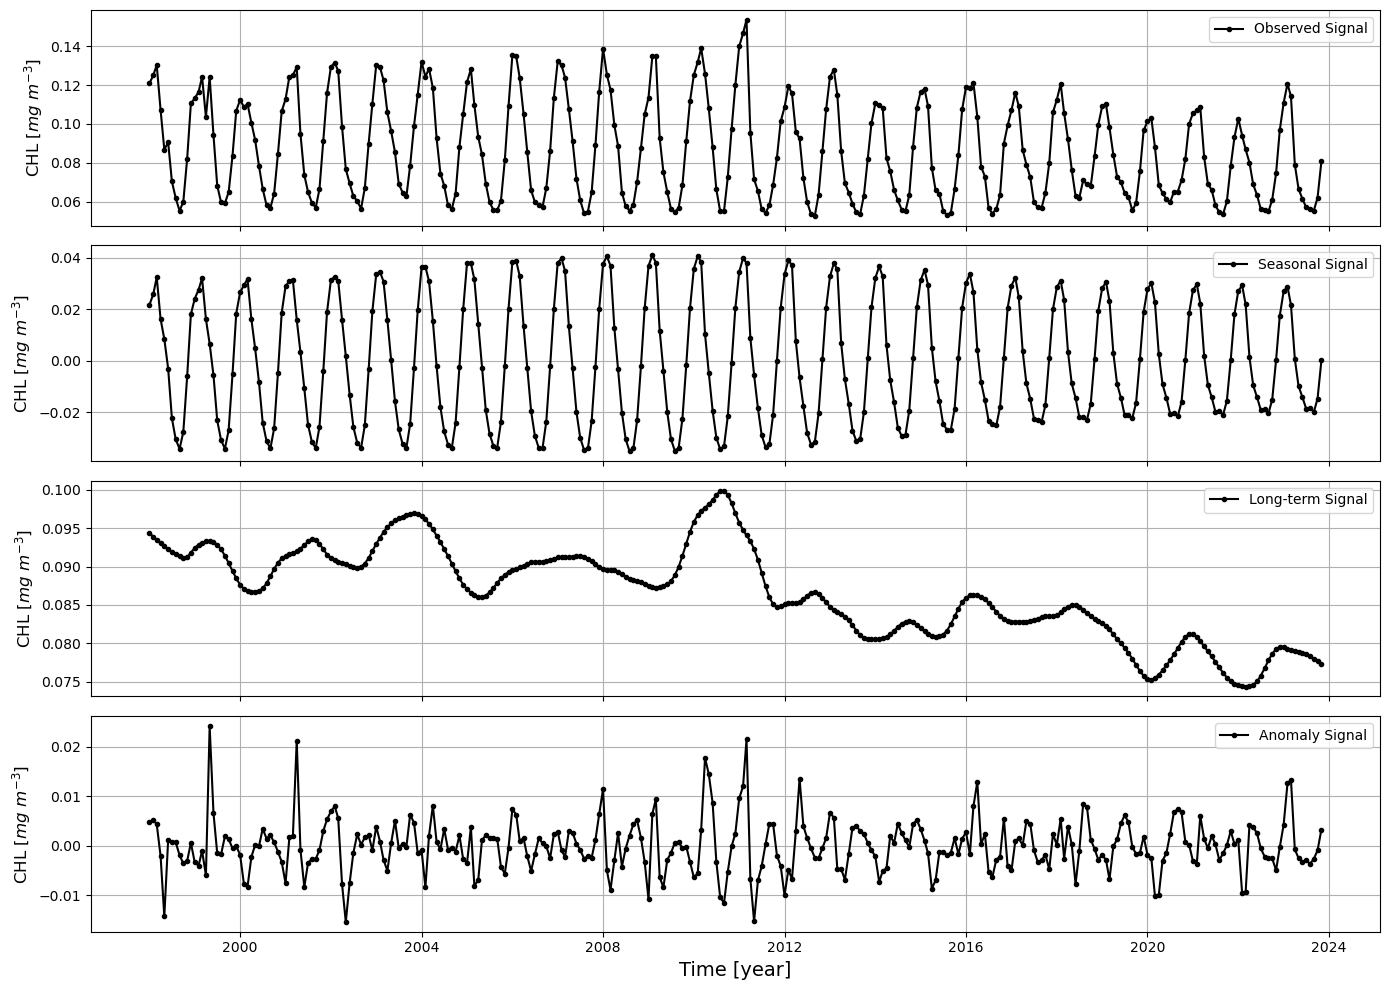

In [138]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot each time series
axs[0].plot(df1.index, df1['Values'], color='black', marker='.', linestyle='-', label='Observed Signal')
axs[1].plot(df2.index, df2['Values'], color='black', marker='.', linestyle='-', label='Seasonal Signal')
axs[2].plot(df3.index, df3['Values'], color='black', marker='.', linestyle='-', label='Long-term Signal')
axs[3].plot(df4.index, df4['Values'], color='black', marker='.', linestyle='-', label='Anomaly Signal')

# Adding titles
axs[0].set_title('', fontsize=14)

for ax in axs:
    ax.grid(True)
    ax.legend(loc='upper right')
    ax.set_ylabel('CHL [$mg$ $m^{-3}$]', fontsize=12)

# Add a common x-axis label
plt.xlabel('Time [year]', fontsize=14)
# Improve the layout
plt.tight_layout()
# Show the plot
plt.show()